### ESE 156 Project - SIF retrievals from TROPOMI
Øyvind Andreas Winton, December 2018.

Notebook walking through the work process of the project. The retrieval is based upon Köhler et al. (2018).

Process:
Define functions
Visualize data files for retrievals
Get the SIF-shape
Get SIF-free spectra for training data for SVD Principal Components
Test a single retrieval
Test a single file
Retrievals for the selected files

Köehler, P., Frankenberg, C.,
Magney, T. S., Guanter, L., Joiner, J.,
& Landgraf, J. (2018). Global
retrievals of solar-induced chlorophyll fluorescence with TROPOMI: First results and intersensor comparison
to OCO-2. Geophysical Research
Letters, 45, 10,456–10,463. https://doi.org/10.1029/2018GL079031

In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from mpl_toolkits.basemap import Basemap
import h5py as h5
import os
from scipy.interpolate import UnivariateSpline
from IPython.display import clear_output

In [2]:
def ForwardModel(x, PC, wl_grid, SIF, compK = False):
    # wl_grid for legendre polynomials
    wl_grid2 = np.linspace(-1,1,len(wl_grid))
    # Legendre polynomials
    P1 = wl_grid2
    P2 = 1/2*(wl_grid2**2 - 1)
    P3 = 1/2*(5*wl_grid2**3 - 3*wl_grid2)
    # Forward model with 5 PCs, based on Köhler 2018
    F = (x[0] * PC[0] + x[1] * PC[1] + x[2] * PC[2] + x[3] * PC[3] + x[4] * PC[4] 
        + x[5] * P1 * PC[0] + x[6] * P2 * PC[0] + x[7] * P3 * PC[0] + x[8] * SIF)
    
    if compK == True:
        # Analytical Jacobian, simple as linear model is simple
        K = np.zeros((122, 9))
        K[:, 0] = PC[0]
        K[:, 1] = PC[1]
        K[:, 2] = PC[2]
        K[:, 3] = PC[3]
        K[:, 4] = PC[4]
        K[:, 5] = P1*PC[0]
        K[:, 6] = P2*PC[0]
        K[:, 7] = P3*PC[0]
        K[:, 8] = SIF
        return F, K
    else:
        return F

In [3]:
def plotfile(filename, directory):
    import os
    file_nadir = os.path.join(directory, filename)
    fn = h5.File(file_nadir)
    lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
    lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
    sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]
    fn.close
    # Plot the solar spectrum sample area, only for SZA<60
    m = Basemap(projection='robin', lon_0=0, resolution='c')
    figsize(16,10)
    m.scatter(lon[sza<60], lat[sza<60], 0.0001, marker='D', latlon=True)
    m.drawcoastlines()
    plt.title('Solar spectrum sample area for this file')
    print('lat', np.max(np.max(lat[sza<60])), np.min(np.min(lat[sza<60])))
    print('lon', np.max(np.max(lon[sza<60])), np.min(np.min(lon[sza<60])))

#### Import a file and see where it has data

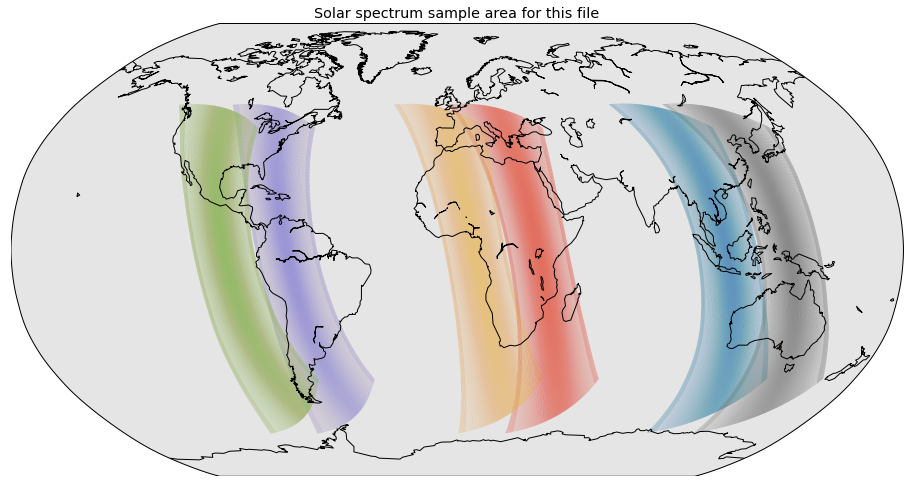

In [4]:
# Retrieval orbits
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.drawcoastlines()
plt.title('Solar spectrum sample area for this file')

directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_RETRIEVAL/'
for filename in os.listdir(directory):
    if filename.endswith('.zip'):
        file_nadir = os.path.join(directory, filename)
        fn = h5.File(file_nadir)
        lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
        lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
        sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]
        fn.close
        m.scatter(lon[sza<60], lat[sza<60], 0.0001, latlon=True)


        

#### Get SIF-shape

In [5]:
# Get SIF shape and wl grid
f = h5.File('/Users/owinton/Documents/TROPOMI/PS_SIF_map.h5','r')
SIF_spec = f['SIF_shape'][:]
SIF_wl = f['wlGrid'][:]
f.close()

### Getting the Principal Components from SVD

####  Get a lot of SIF-free spectra for each detector spatial pixel

In [30]:
# Get spectra for each pixel (in practice each individual spectrometer across the swath)
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA/'
# Number of training data
nspec = 400
# Truncate outer 20 pixels on each edge, 408 pixels remain. 497 spectral values for each spectrum
spec_pixel_all = np.zeros((nspec, 408, 497))
wl_pixel_all = np.zeros((408, 497))
# To keep track of how many spectra found for each pixel
count = np.zeros((408))
# Lat, lon for the training data
samplelat = np.zeros((nspec, 408))
samplelon = np.zeros((nspec, 408))

# Check each file
for filename in os.listdir(directory):
    if count.all == 400:
        continue
    if filename.endswith('.zip'):
        file_nadir = os.path.join(directory, filename)
        fn = h5.File(file_nadir)
        # Get the data, remove 20 pixels on each edge
        lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,20:428]
        lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,20:428]
        sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,20:428]
        wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,20:428,:]
        spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,20:428,:]
        fn.close()
        
        # For each pixel (get rid of 20 edge pixels on each side)
        for pixel in range(408):
            # wl_grid is defined within the pixel
            wl_pixel_all[pixel, :] = wl_spec[pixel, :]
            # Check each swath
            for swath in range(np.shape(lat)[0]):
                # Find spectra in Sahara
                if (lat[swath, pixel] > 18 and lat[swath,pixel] < 28 and lon[swath,pixel] > -8 and lon[swath,pixel] < 28 and sza[swath, pixel] < 40 and count[pixel] < nspec):
                    spec_pixel_all[int(count[pixel]), pixel, :] = spec[swath, pixel, :]
                    samplelat[int(count[pixel]), pixel] = lat[swath,pixel]
                    samplelon[int(count[pixel]), pixel] = lon[swath,pixel]
                    count[pixel] += 1
                # Find spectra in a region in the Pacific    
                if (lat[swath, pixel] > -60 and lat[swath, pixel] < 10 and lon[swath, pixel] > -160 and lon[swath, pixel] < - 90 and sza[swath, pixel] < 40 and count[pixel] < nspec):
                    spec_pixel_all[int(count[pixel]), pixel, :] = spec[swath, pixel, :]
                    samplelat[int(count[pixel]), pixel] = lat[swath,pixel]
                    samplelon[int(count[pixel]), pixel] = lon[swath,pixel]
                    count[pixel] += 1
            # Give progress info
            clear_output(wait=True)
            print("Current progress",pixel+1, "pixels done")


Current progress 408 pixels done


Text(0.5,1,'Solar spectrum sample area')

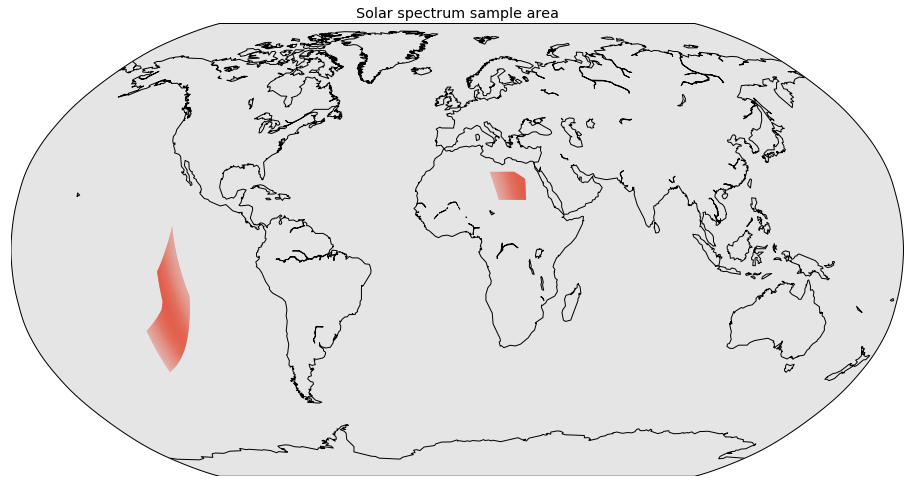

In [31]:
# Plot the solar spectrum sample area
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(samplelon, samplelat, 0.0001, marker='D', latlon=True)
m.drawcoastlines()
plt.title('Solar spectrum sample area')

### Truncate the spectra

In [32]:
# Get the first 122 wavelengths above 743 nm, this is our retrieval area. Simpler than getting all pixels 743-758
# Fixed amount of spectral values in each pixel to make matrices easier, could have variable length as each pixel has a different grid
wl_spec = np.zeros((408, 122))
spec = np.zeros((nspec, 408, 122))
for pixel in range(408):
    # Index of pixels above 743
    index = wl_pixel_all[pixel, :] > 743
    # The wl_grid for this pixel
    wl_pixel = wl_pixel_all[pixel, index]
    # Save only 122 wavelengths
    wl_spec[pixel, :] = wl_pixel[:122]
    for swath in range(nspec):
        # Extract the spectral value corresponding to the wavelength grid
        spec_pixel = spec_pixel_all[swath, pixel, index]
        spec[swath, pixel, :] = spec_pixel[:122]

### Do the SVD and show some of the PC-functions and their explained variance

In [33]:
u = np.zeros((408, nspec, nspec))
s = np.zeros((408, 122))
# The eigenvectors for the spectra are the ones we are interested in. 
# u or vh depending on how the spectral matrix is set up
# Here matrix is spec[swath, pixel, wavelength]
vh = np.zeros((408, 122, 122))
for pixel in range(408):
    u[pixel,:,:], s[pixel,:], vh[pixel,:,:] = np.linalg.svd(spec[:, pixel, :])
    # For each pixel, the rows (vh is v transposed) are the eigen vectors;
    # Use the first 5 as principal components for SIF-free spectra i.e. 'pure' reflected solar spectrum

[1.81918424e-04 5.43512671e-07 1.46415390e-07 8.89639814e-08
 3.71616579e-08 3.17147264e-08 2.23602938e-08 1.18874132e-08
 1.05668164e-08 8.87167116e-09]


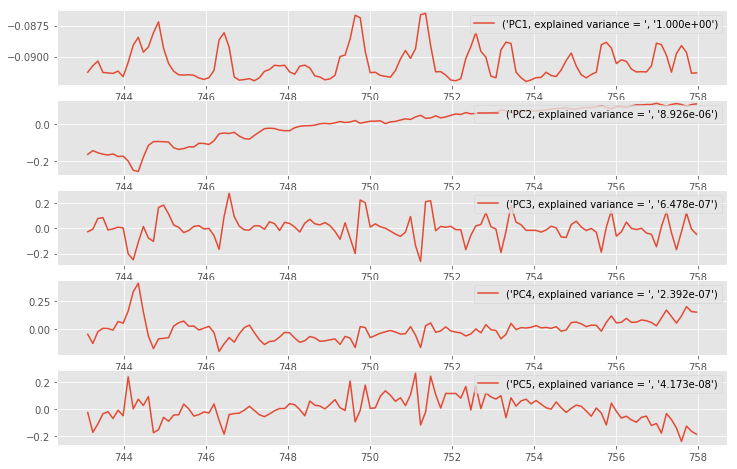

In [34]:
# Showing the Principal component functions, along with their explained variance 
figsize(12,8)
plt.subplot(511)
test_pixel = 0
plt.plot(wl_spec[0,:],vh[test_pixel,0,:],label=('PC1, explained variance = ', '{:0.3e}'.format(s[test_pixel,0]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(512)
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,1,:],label=('PC2, explained variance = ', '{:0.3e}'.format(s[test_pixel,1]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(513)
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,2,:],label=('PC3, explained variance = ', '{:0.3e}'.format(s[test_pixel,2]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(514)
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,3,:],label=('PC4, explained variance = ', '{:0.3e}'.format(s[test_pixel,3]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(515)
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,4,:],label=('PC5, explained variance = ', '{:0.3e}'.format(s[test_pixel,4]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)

print(s[test_pixel,0:10])


### Testing one single retrieval

In [35]:
# The 'coordinates' of the test pixel
swath, pixel = 200, 100
# The principal components are different for each pixel
PC = vh[pixel, 0:5]
# The wl_grid is different for each pixel
wl_grid = wl_spec[pixel, :]
# Interpolate the SIF-shape to our grid
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
SIF = spl(wl_grid)
# Just to get the Jacobian
F, K = ForwardModel(np.ones(9), PC, wl_grid, SIF, True)
spec_it = spec[swath, pixel, :]
# Noise model from Christian
noise = 0*0.006014361 + 0.003470511 * np.sqrt(spec_it)
invSe = np.diag(1/noise**2)

[-1.85247238e-05 -5.68607366e-08 -2.47791713e-08 -4.15709475e-09
 -3.74964015e-09 -6.70664482e-08 -6.02388455e-09  6.39663819e-10
 -3.78481612e-09]


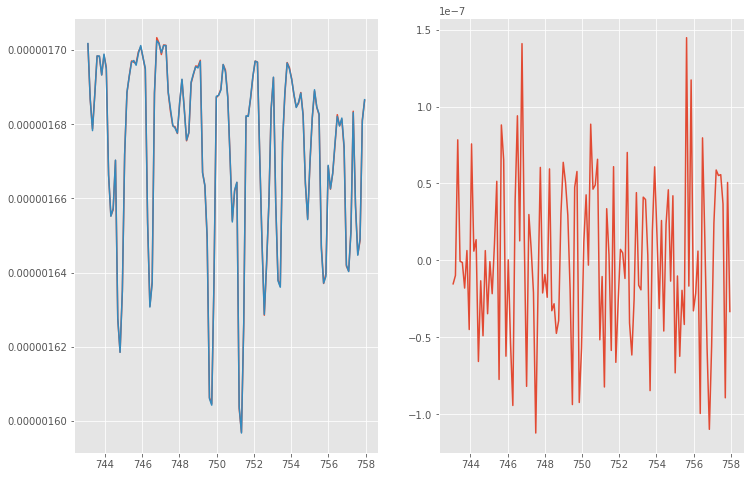

In [36]:
# Linear weighted retriaval
x = np.linalg.inv(K.T.dot(K)).dot(K.T).dot(spec_it)
print(x)
plt.subplot(121)
# Linear: forwar dmodel is Kx
plt.plot(wl_grid, spec_it, wl_grid, K.dot(x))
plt.subplot(122)
plt.plot(wl_grid, (spec_it - K.dot(x))/(0.006014361 + 0.003470511 * np.sqrt(spec_it)))

### Testing retrieval on Sahara pixels

In [37]:
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
factor = 1
xhat = np.zeros((nspec, 408, 9))
residuals = np.zeros((nspec, 408, 122))
for pixel in range(408):
    # The Principal component
    PC = vh[pixel, 0:5, :]
    # The wl_grid and SIF for this pixel
    wl_grid = wl_spec[pixel, :]
    SIF = spl(wl_grid)
    # Get the Jacobian, it's the same for all spectra from a given pixel
    F, K = ForwardModel(np.ones(9), PC, wl_grid, SIF, True)
    for swath in range(nspec):
        spec_it = spec[swath, pixel, :]
        # Noise model
        noise = 0.006014361 + 0.003470511 * np.sqrt(spec_it)
        invSe = np.diag(1/noise**2)
        # Linear retrieval with prior could be implemented, as we expect factor on higher PC functions to be 0
        # Would need to define xa, Sa - should draw upon singular values as well
        # xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K) + invSa ).dot( (K.T).dot(invSe).dot(spec_it) + invSa.dot(xa) )
        # Here just weighted linear retrieval
        xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K)  ).dot( (K.T).dot(invSe).dot(spec_it) )

        # Save the residuals
        residuals[swath, pixel, :] = spec_it - K.dot(xhat[swath,pixel,:])
    
    # Progress info
    clear_output(wait=True)
    print("Current progress",np.round(((pixel+1)/408) * 100, 1), "%")
        

Current progress 100.0 %


Text(0.5,1,'SIF retrievals')

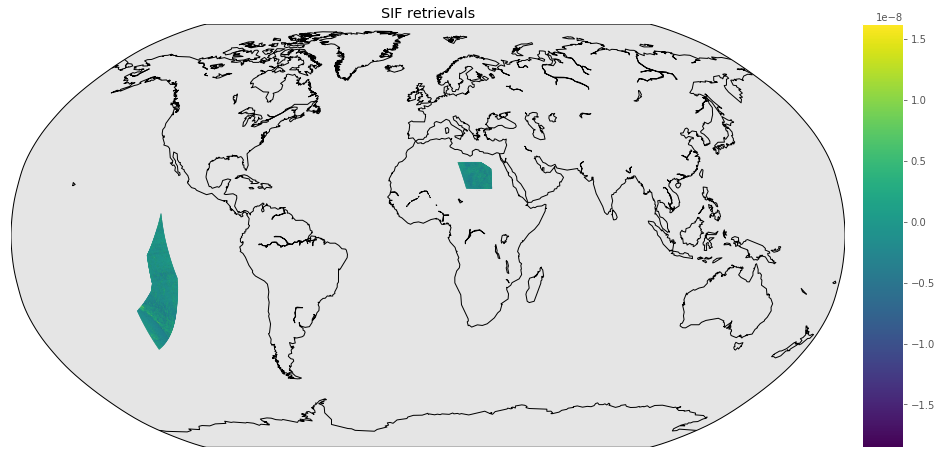

In [38]:
SIF_retrievals = xhat[:, :, 8]
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(samplelon, samplelat, s = 0.01, c = SIF_retrievals, latlon=True)
m.colorbar()
m.drawcoastlines()
plt.title('SIF retrievals')

### Fits and residuals look good

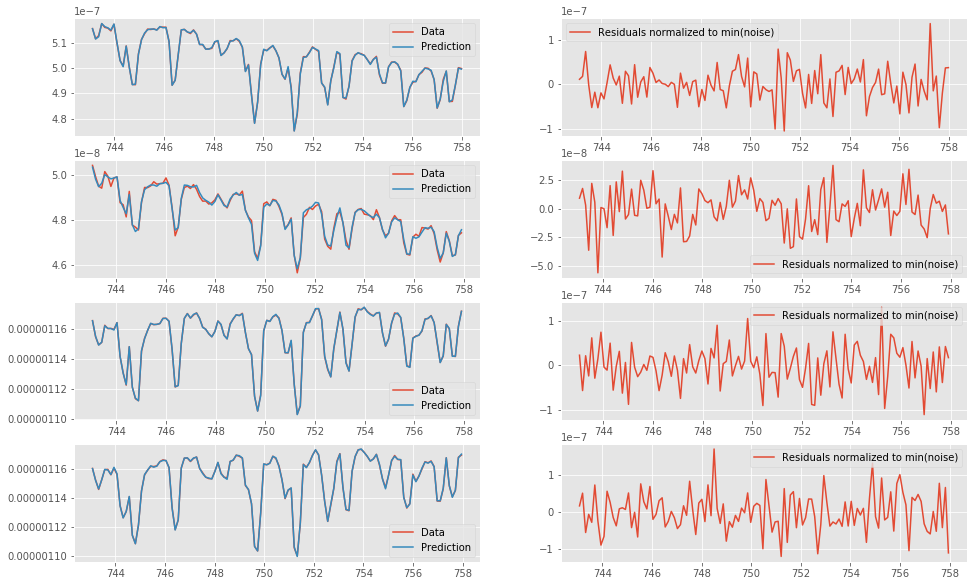

In [39]:
plt.subplot(421)
swath, pixel = 300, 10
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], vh[pixel, 0:5, :], wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(422)
noise = 0.006014361 + 0.003470511 * np.sqrt(spec[swath, pixel, :])
plt.plot(wl_spec[pixel,:], residuals[swath, pixel, :]/np.min(noise))
plt.legend(['Residuals normalized to min(noise)'])
plt.subplot(423)
swath, pixel = 200, 40
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], vh[pixel, 0:5, :], wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(424)
noise = 0.006014361 + 0.003470511 * np.sqrt(spec[swath, pixel, :])
plt.plot(wl_spec[pixel,:], residuals[swath, pixel, :]/np.min(noise))
plt.legend(['Residuals normalized to min(noise)'])
plt.subplot(425)
swath, pixel = 100, 80
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], vh[pixel, 0:5, :], wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(426)
noise = 0.006014361 + 0.003470511 * np.sqrt(spec[swath, pixel, :])
plt.plot(wl_spec[pixel,:], residuals[swath, pixel, :]/np.min(noise))
plt.legend(['Residuals normalized to min(noise)'])
plt.subplot(427)
swath, pixel = 10, 110
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], vh[pixel, 0:5, :], wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(428)
noise = 0.006014361 + 0.003470511 * np.sqrt(spec[swath, pixel, :])
plt.plot(wl_spec[pixel,:], residuals[swath, pixel, :]/np.min(noise))
plt.legend(['Residuals normalized to min(noise)'])

### Retrieval of one file at a time

In [16]:
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA'
filename = 'S5P_OFFL_L1B_RA_BD6_20181012T102851_20181012T121021_05165_01_010000_20181012T140022.zip'
file_nadir = os.path.join(directory, filename)
fn = h5.File(file_nadir)
lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,20:428]
lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,20:428]
sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,20:428]
wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,20:428,:]
spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,20:428,:]
fn.close()

In [17]:
# Similar to the earlier truncation of spectra. Could probably be implemented in a smarter and more efficient way
spec_pixel_trunc = np.zeros((lat.shape[0], 408, 122))
wl_pixel_trunc = np.zeros((408, 122))
for pixel in range(408):
    index_pixel = wl_pixel_all[pixel, :] > 743
    wl_pixel = wl_pixel_all[pixel, index_pixel]
    wl_pixel_trunc[pixel, :] = wl_pixel[:122]
    for swath in range(lat.shape[0]):
        spec_pixel = spec[swath, pixel, index_pixel]
        spec_pixel_trunc[swath, pixel, :] = spec_pixel[:122]
wl_spec = wl_pixel_trunc
spec = spec_pixel_trunc

In [18]:
# Retrieval similar to single spectra
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
factor = 1
xhat = np.zeros((lat.shape[0], lat.shape[1], 9))
residuals = np.zeros((lat.shape[0], lat.shape[1], 122))
for pixel in range(408):
    PC = vh[pixel, 0:5, :]
    wl_grid = wl_spec[pixel, :]
    SIF = spl(wl_grid)
    F, K = ForwardModel(np.ones(9), PC, wl_grid, SIF, True)
    for swath in range(lat.shape[0]):
        if sza[swath, pixel] < 60:
            noise = 0.006014361 + 0.003470511 * np.sqrt(spec_it)
            invSe = np.diag(1/noise**2)
            spec_it = spec[swath, pixel, :]
            xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K) + invSa ).dot( (K.T).dot(invSe).dot(spec_it) + invSa.dot(xa) )
            residuals[swath, pixel, :] = spec_it - K.dot(xhat[swath, pixel, :])
        else:
            residuals[swath, pixel, :] = spec_it
    clear_output(wait=True)
    print("Current progress",np.round(((pixel+1)/408) * 100, 1), "%")

   

Current progress 100.0 %


### Fits and residuals look good, however feature around 744nm - within noise.

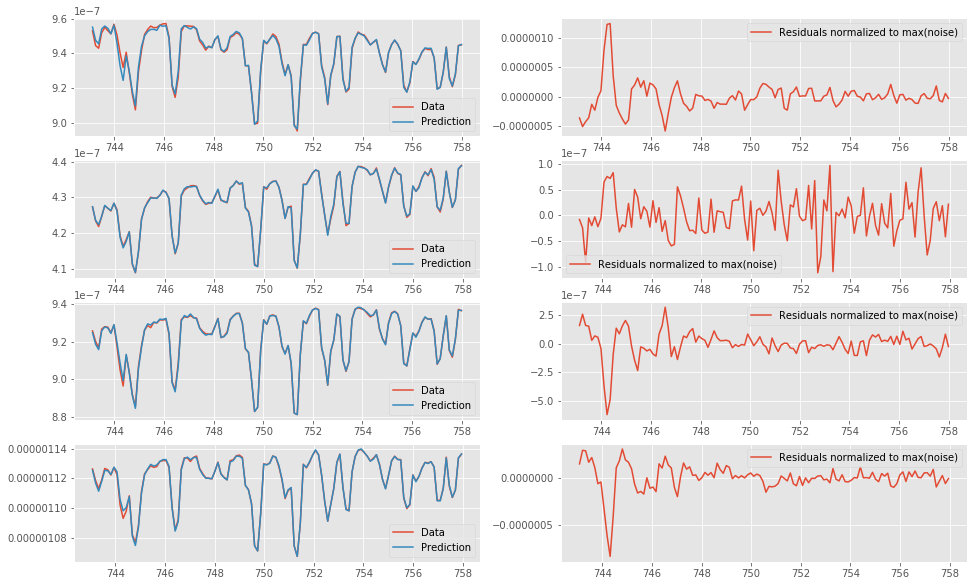

In [19]:
plt.subplot(421)
swath, pixel = 1000, 10
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], vh[pixel, 0:5, :], wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(422)
noise = 0.006014361 + 0.003470511 * np.sqrt(spec[swath, pixel, :])
plt.plot(wl_spec[pixel,:], residuals[swath, pixel, :]/np.min(noise))
plt.legend(['Residuals normalized to min(noise)'])
plt.subplot(423)
swath, pixel = 1500, 30
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], vh[pixel, 0:5, :], wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(424)
noise = 0.006014361 + 0.003470511 * np.sqrt(spec[swath, pixel, :])
plt.plot(wl_spec[pixel,:], residuals[swath, pixel, :]/np.min(noise))
plt.legend(['Residuals normalized to min(noise)'])
plt.subplot(425)
swath, pixel = 2000, 70
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], vh[pixel, 0:5, :], wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(426)
noise = 0.006014361 + 0.003470511 * np.sqrt(spec[swath, pixel, :])
plt.plot(wl_spec[pixel,:], residuals[swath, pixel, :]/np.min(noise))
plt.legend(['Residuals normalized to min(noise)'])
plt.subplot(427)
swath, pixel = 2000, 110
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], vh[pixel, 0:5, :], wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(428)
noise = 0.006014361 + 0.003470511 * np.sqrt(spec[swath, pixel, :])
plt.plot(wl_spec[pixel,:], residuals[swath, pixel, :]/np.min(noise))
plt.legend(['Residuals normalized to min(noise)'])

Text(0.5,1,'SIF retrievals')

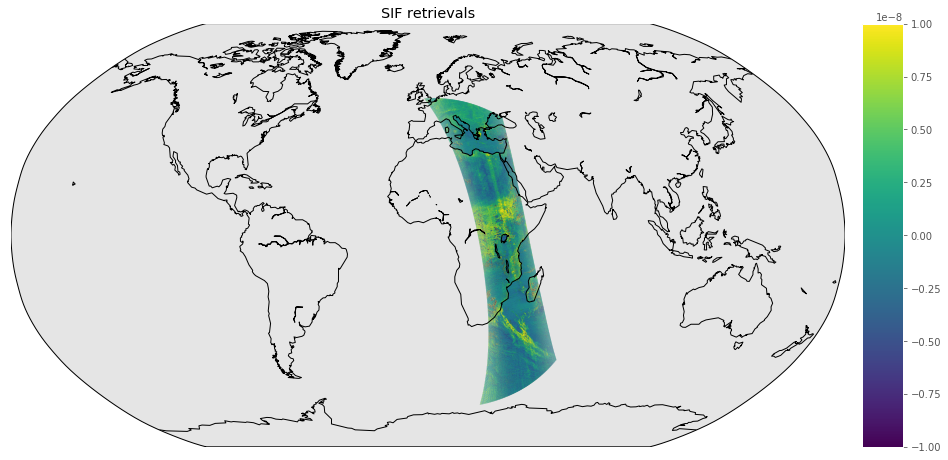

In [20]:
SIF_retrievals = xhat[:, :, 8]
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(lon[sza<60], lat[sza<60], s = 0.001, c = SIF_retrievals[sza<60], latlon=True, vmin=-1e-8, vmax=1e-8)
m.colorbar()
m.drawcoastlines()
plt.title('SIF retrievals')


### Go global. Save only lat, lon, sza, xhat

In [21]:
# Prerequisites: PCs have to be done. Everything else we get from the data.
# Just testing a few files the first time around
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_RETRIEVAL/'
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
# Data storage for the total retrieval
lat = np.zeros((0, 408))
lon = np.zeros((0, 408))
sza = np.zeros((0, 408))
wl_spec = np.zeros((408, 122))
xhat = np.zeros((0, 408, 9))


In [25]:
# Retrieval and truncation similar to earlier retrievals. See single spectrum retrieval
filecount = 0
for filename in os.listdir(directory):
    # Go through each file
    if filename.endswith('.zip'):
        file_nadir = os.path.join(directory, filename)
        fn = h5.File(file_nadir)
        # Get the data, remove 20 pixels on each edge
        lat_file = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,20:428]
        lon_file = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,20:428]
        sza_file = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,20:428]
        wl_spec_file = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,20:428,:]
        spec_file = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,20:428,:]
        fn.close()
        nswaths = lat_file.shape[0]
        
        # Truncate the spectra
        spec_trunc_file = np.zeros((nswaths, 408, 122))
        wl_spec_trunc_file = np.zeros((408, 122))
        for pixel in range(408):
            wl_index_pixel = wl_spec_file[pixel, :] > 743
            wl_spec_pixel = wl_spec_file[pixel, wl_index_pixel]
            wl_spec_trunc_file[pixel, :] = wl_spec_pixel[:122]
            for swath in range(nswaths):
                spec_trunc_file_pixel = spec_file[swath, pixel, wl_index_pixel]
                spec_trunc_file[swath, pixel, :] = spec_trunc_file_pixel[:122]
        wl_spec_file = wl_spec_trunc_file
        spec_file = spec_trunc_file
        
        # Do the retrievals
        xhat_file = np.zeros((nswaths, 408, 9))
        residuals_file = np.zeros((nswaths, 408, 122))    
        for pixel in range(408):
            PC = vh[pixel, 0:5, :]
            # wl_grid only used in this retrieval. wl_spec are the same for each swath.
            wl_grid = wl_spec_file[pixel, :]
            SIF = spl(wl_grid)
            F, K = ForwardModel(np.ones(9), PC, wl_grid, SIF, True)
            for swath in range(nswaths):
                if sza_file[swath, pixel] < 60:
                    noise = 0.006014361 + 0.003470511 * np.sqrt(spec_it)
                    invSe = np.diag(1/noise**2)
                    spec_it = spec_file[swath, pixel, :]
                    xhat_file[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K)).dot( (K.T).dot(invSe).dot(spec_it))
                    residuals_file[swath, pixel, :] = spec_it - K.dot(xhat_file[swath, pixel, :])
                else:
                    residuals_file[swath, pixel, :] = spec_it
            clear_output(wait=True)
            print("Current progress",np.round(((pixel+1)/408) * 100, 1), "%")
            
            
        # At the end of the file, concatenate file retrievals to total retrievals
        # Could possibly be implemented differently to avoid storign large arrays in memory
        lat = np.concatenate((lat, lat_file), axis = 0)
        lon = np.concatenate((lon, lon_file), axis = 0)
        sza = np.concatenate((sza, sza_file), axis = 0)
        xhat = np.concatenate((xhat, xhat_file), axis = 0)
        filecount += 1
        print(filecount, 'files done')

   

Current progress 100.0 %
6 files done


Text(0.5,1,'Retrievals of 1st state vector')

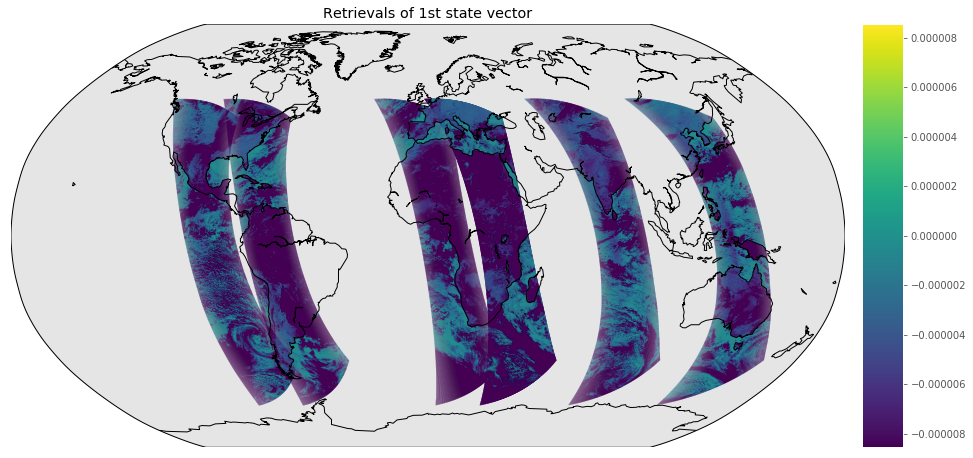

In [26]:
# Plotting different state vectors
statevector = 0
retrievals = xhat[:, :, statevector]
lims = np.sqrt(np.mean(xhat[:, :, 0][sza<60]**2))
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(lon[sza<60], lat[sza<60], s = 0.001, c = retrievals[sza<60], latlon=True, vmin=-lims, vmax=lims)
m.colorbar()
m.drawcoastlines()
plt.title('Retrievals of 1st state vector')

Text(0.5,1,'Retrievals of 6th state vector')

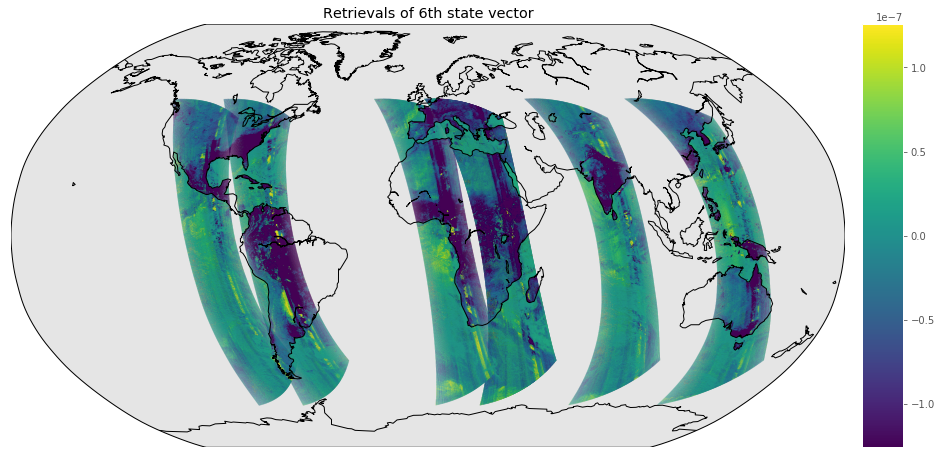

In [27]:
statevector = 5
retrievals = xhat[:, :, statevector]
lims = np.sqrt(np.mean(xhat[:, :, statevector][sza<60]**2))
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(lon[sza<60], lat[sza<60], s = 0.001, c = retrievals[sza<60], latlon=True, vmin=-lims, vmax=lims)
m.colorbar()
m.drawcoastlines()
plt.title('Retrievals of 6th state vector')

Text(0.5,1,'Retrievals of SIF')

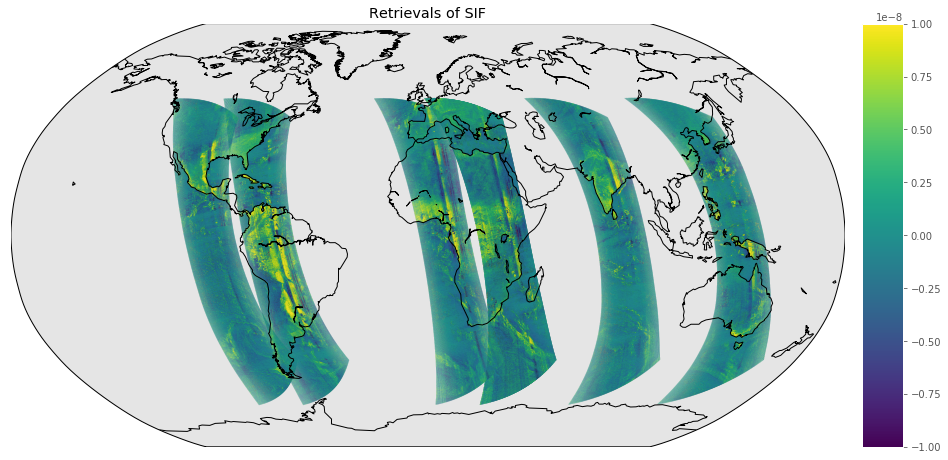

In [28]:
statevector = 8
retrievals = xhat[:, :, statevector]
lims = np.sqrt(np.mean(xhat[:, :, statevector][sza<60]**2))
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(lon[sza<60], lat[sza<60], s = 0.001, c = retrievals[sza<60], latlon=True, vmin=-1e-8, vmax=1e-8)
m.colorbar()
m.drawcoastlines()
plt.title('Retrievals of SIF')

Text(0.5,1,'Retrievals of SIF')

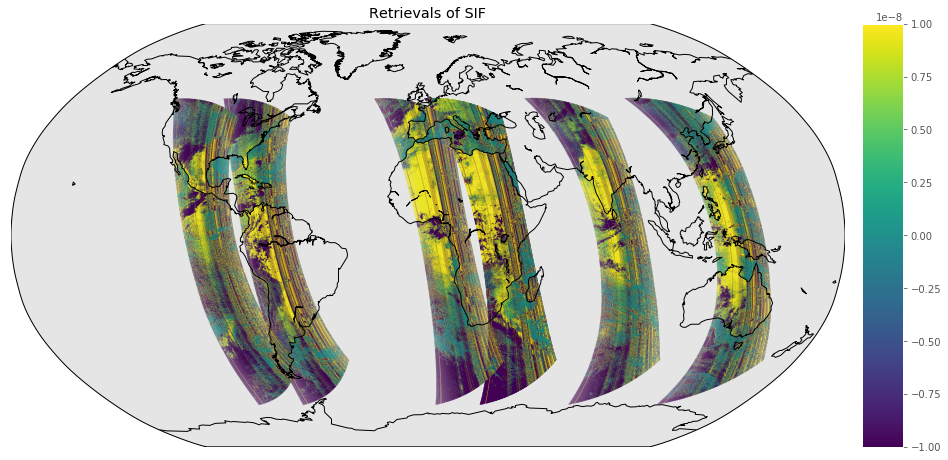

In [29]:
statevector = 1
retrievals = xhat[:, :, statevector]
lims = np.sqrt(np.mean(xhat[:, :, statevector][sza<60]**2))
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(lon[sza<60], lat[sza<60], s = 0.001, c = retrievals[sza<60], latlon=True, vmin=-1e-8, vmax=1e-8)
m.colorbar()
m.drawcoastlines()
plt.title('Retrievals of 2nd state vector')